# AirburstSolver User Guide

This jupyter notebook introduces the functionalities available as part of the the solver module of armageddon package. The solver contains the following:

- Planet class which holds the parameters specific to the target planet including atmospheric density profile and certain constants for the dynamics of an asteroid in the planet's atmosphere. The class exposes three methods to the user:
    - solve_atmospheric_entry
    - calculate_result
    - analyse outcome

    Each of the available functionalities are explained in detail below

Import the class as follows

In [1]:
from armageddon import Planet

The constructor sets the following default values which can be set by the user:

- atmos_func='exponential'
    - Atmospheric density profile. Available options are: `exponential`, `tabular`, `constant`
- atmos_filename
    - Path to the file containing atmospheric density ($kg/m^3$) profile with respect to altitude (m)
- Cd=1
    - Coefficient of Drag
- Ch=0.1
    - Ablation efficiency coefficient
- Q=1e7
    - Specific heat of ablation
- Cl=1e-3
    - Coefficient of Lift
- alpha=0.3
    - Dispersion coefficient
- Rp=6371e3
    - Radius of the planet. Default is the radius of earth
- g=9.81
    - Gravitational acceleration. Default is the gravitational acceleration of earth
- H=8000
    - Atmospheric scale height for the exponential density model (m)
- rho0=1.2
    - Air density at zero altitude

In [2]:
# Instantiating object with atmospheric profile as tabular
earth = Planet()

The dynamics of the asteroid in planets atmosphere can be solved by calling the method solve_atmospheric_entry. The arguments are:

- radius
    - Radius of the asteroid. Shape will be taken to be spherical with this radius  (m)
- velocity
    - Entry speed of the asteroid (m/s)
- density
    - Density of the asteroid material $kg/m^3$
- strength
    - The strength of the asteroid (i.e. the maximum pressure it can take before fragmenting) in $N/m^2$
- angle
    - Angle with the horizontal at entry (deg/rad)
- init_altitude=100e3
    - Altitude at entry
- dt=0.05
    - Time step for required output from solver (s)
- radians=False
    - True if input angle is in radians
- method='RK45'
    - Integration algorithm to be used. Options are `Euler`, `RK4` and `Rk45`. Euler and RK4 are constant step-size solvers while RK45 uses adaptive step-size

In [3]:
input = {'radius': 9.75,
         'velocity': 19e3,
         'density': 3300.,
         'strength': 2e6,
         'angle': 20.,
         'init_altitude': 100e3}

result = earth.solve_atmospheric_entry(**input)

The output is a pandas DataFrame that contains the followig columns:

'velocity', 'mass', 'angle', 'altitude','distance', 'radius', 'time'

The state vector values are available at the time step specified (Default=0.05s). The solver terminates at any of following stopping conditions:

1. Velocity(Speed) becoming zero
2. Mass becoming zero
3. Altitude becoming zero
4. Range becoming greater than the diameter of earth

**Note**: For both constant and adaptive step size, the integration terminates one step after the overshoot. This has been done to ensure that the output contains a data-point which is can be used for linear interpolation to approximately find the time of 0 cross-over if required. The adaptive step size only changes to account for error tolerance and not for event detection.

In [4]:
result.head()

,velocity,mass,angle,altitude,distance,radius,time
0,19000.000000,1.281198e+07,20.000000,100000.000000,0.000000,9.75,0.00
1,19000.166775,1.281198e+07,19.993485,99675.130189,878.956579,9.75,0.05
2,19000.333457,1.281198e+07,19.986970,99350.359043,1758.001362,9.75,0.10
3,19000.500045,1.281198e+07,19.980454,99025.686580,2637.134334,9.75,0.15
4,19000.666538,1.281197e+07,19.973937,98701.112819,3516.355479,9.75,0.20


In [5]:
result.tail()

,velocity,mass,angle,altitude,distance,radius,time
8287,32.311179,2.086686e+06,89.942314,5.613256,214687.431484,102.367553,414.35
8288,32.307892,2.086686e+06,89.942314,3.997780,214687.433110,102.367553,414.40
8289,32.304606,2.086685e+06,89.942314,2.382468,214687.434736,102.367553,414.45
8290,32.301320,2.086685e+06,89.942314,0.767321,214687.436362,102.367553,414.50
8291,32.298263,2.086685e+06,89.942314,-0.735709,214687.437876,102.367553,414.55


The above result can then be used to calculate the loss of kinetic energy per unit altitude. This gives an approximation of the energy lost to the atmosphere as heat. The energy deposited can be obtained by calling the method calculate_energy which returns the DataFrame obtained above with a new column `dedz` (units kT/km) added to it which is calculated using the central difference for points between the first and last time step, forward difference for the first time step and backward difference for the last time step.

In [6]:
result = earth.calculate_energy(result)
result.head()

,velocity,mass,angle,altitude,distance,radius,time,dedz
0,19000.000000,1.281198e+07,20.000000,100000.000000,0.000000,9.75,0.00,-0.029557
1,19000.166775,1.281198e+07,19.993485,99675.130189,878.956579,9.75,0.05,-0.029547
2,19000.333457,1.281198e+07,19.986970,99350.359043,1758.001362,9.75,0.10,-0.029527
3,19000.500045,1.281198e+07,19.980454,99025.686580,2637.134334,9.75,0.15,-0.029505
4,19000.666538,1.281197e+07,19.973937,98701.112819,3516.355479,9.75,0.20,-0.029483


**Note**: The value of dedz can sometimes be seen to start with negative values for certain combination of parameters (as seen above). This means that the kinetic energy is increasing with decrease in altitude which is a possible scenario as when the gain in speed (gravitational force larger than drag) outweighs the loss of mass. 

The resulting dataframe can then be analysed to identify the impact parameters:
- `outcome` : `Airburst` or `Cratering`
- `burst_peak_dedz`
- `burst_altitude`
- `burst_distance`
- `burst_energy`

By calling the analyse_outcome method

In [7]:
outcome = earth.analyse_outcome(result)
outcome

{'outcome': 'Airburst',
 'burst_peak_dedz': 91.49271571624418,
 'burst_altitude': 31425.334946666408,
 'burst_distance': 194027.08322546008,
 'burst_energy': 361.10530125690303}

The analysis is visualised using plots below

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_out(result, outcome):

    fig = plt.figure(figsize=(10, 10), constrained_layout=True)
    GridSpec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

    subfig1 = fig.add_subfigure(GridSpec[0, 0])
    subfig2 = fig.add_subfigure(GridSpec[0, 1])

    ax1 = subfig1.add_subplot(111)
    ax2 = subfig2.subplots(3, 2)
    axs = ax2.flatten()

    ax1.plot(result.dedz, result.altitude*1e-3)
    ax1.axhline(y = outcome["burst_altitude"]*1e-3, color = 'r', linestyle = '--')
    ax1.annotate('burst_peak_dedz', xy=(outcome["burst_peak_dedz"], outcome["burst_altitude"]*1e-3),
                 xytext=(0.6*outcome["burst_peak_dedz"], outcome["burst_altitude"]*1e-3+ 5),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    ax1.annotate("burst_altitude", (0.3*outcome["burst_peak_dedz"], outcome["burst_altitude"]*1e-3+ 1))
    ax1.set_title("Energy Deposition Curve: " + outcome["outcome"])
    ax1.set_xlabel("Energy lost per unit height (kT/km)")
    ax1.set_ylabel("Altitude (km)")


    axs[0].plot(result.time, result.velocity)
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Velocity (m/s)")
    axs[1].plot(result.time, result.mass)
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Mass (kg)")
    axs[2].plot(result.time, result.angle)
    axs[2].set_xlabel("Time (s)")
    axs[2].set_ylabel("Angle")
    axs[3].plot(result.time, result.altitude)
    axs[3].set_xlabel("Time (s)")
    axs[3].set_ylabel("Altitude (m)")
    axs[4].plot(result.time, result.distance)
    axs[4].set_xlabel("Time (s)")
    axs[4].set_ylabel("Distance (m)")
    axs[5].plot(result.time, result.radius)
    axs[5].set_xlabel("Time (s)")
    axs[5].set_ylabel("Radius (m)")

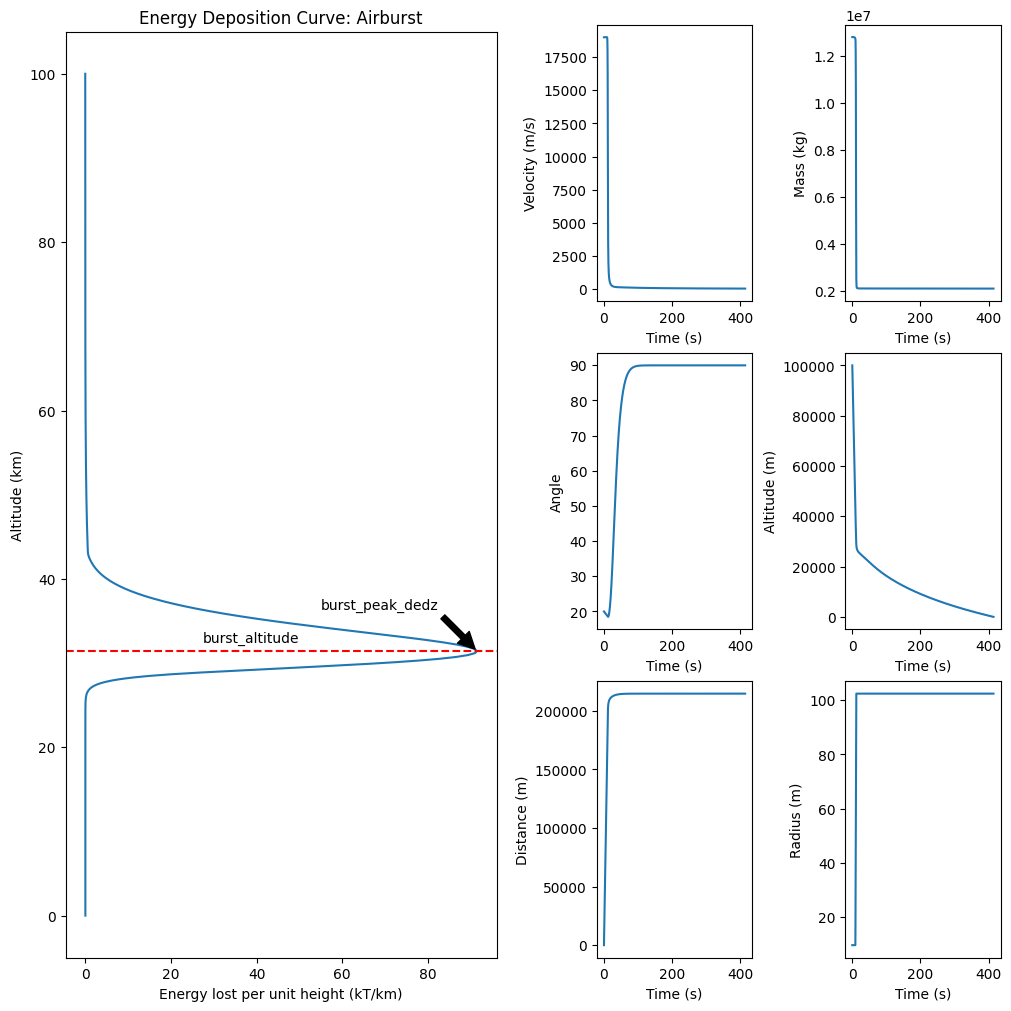

In [9]:
plot_out(result, outcome)

### Cratering Example

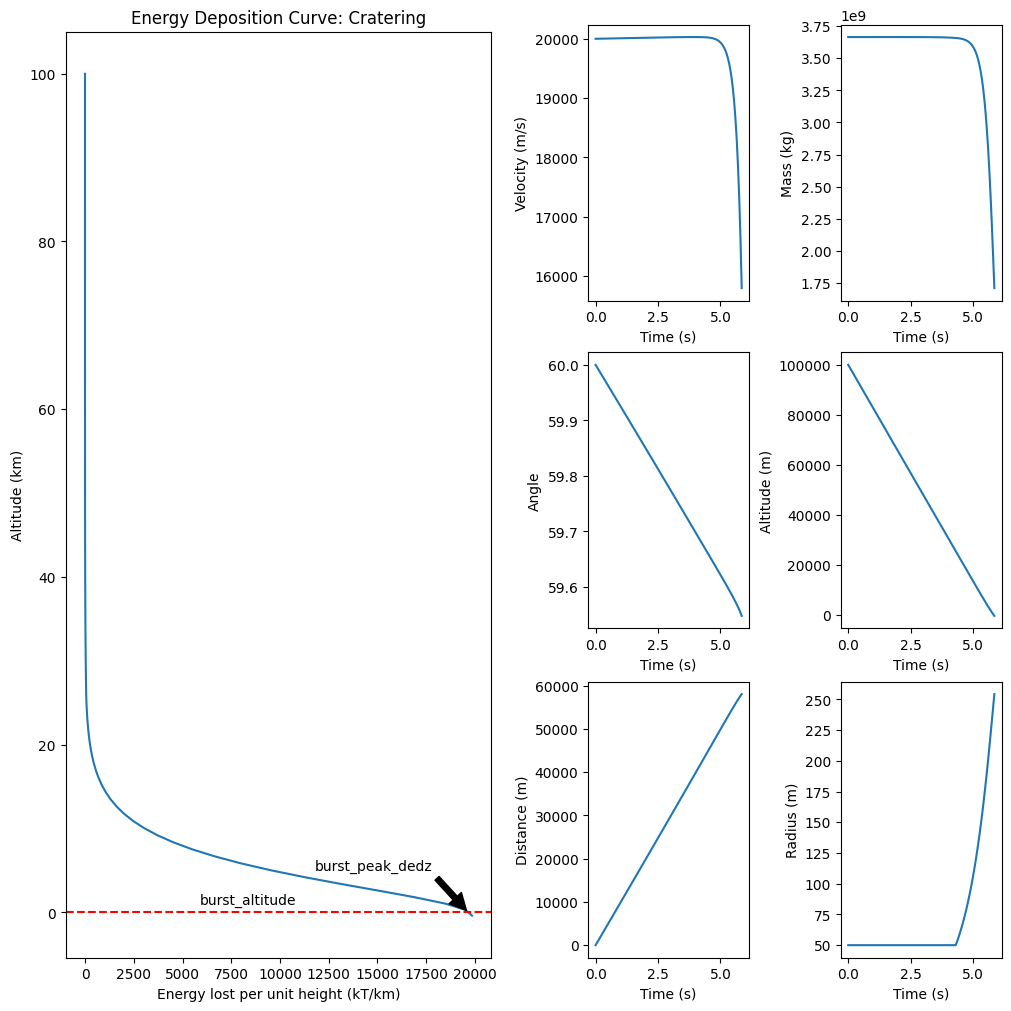

In [10]:
input = {'radius': 50,
         'velocity': 20e3,
         'density': 7000.,
         'strength': 2e7,
         'angle': 60,
         'init_altitude': 100e3}

result = earth.solve_atmospheric_entry(**input)
result = earth.calculate_energy(result)
outcome = earth.analyse_outcome(result)
plot_out(result, outcome)

In [11]:
outcome

{'outcome': 'Cratering',
 'burst_peak_dedz': 19663.838902840696,
 'burst_altitude': 0.0,
 'burst_distance': 57792.93316160227,
 'burst_energy': 116758.92480298487}